## Importing necessary Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tqdm
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.utils.data as data
import torchvision.models as models
import torchvision.datasets as datasets
import copy
from tqdm.notebook import tqdm as tqdm
import time
import time
# import onnxruntime
from time import perf_counter
import timeit
import torch.nn.utils.prune as prune
import torch.quantization as quant
def timer(f,*args):   
    start = perf_counter()
    f(*args)
    return (1000 * (perf_counter() - start))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Preprocessing

In [ ]:
# Define the data transformation pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Load the CIFAR10 cifar10_dataset and apply the transformation pipeline
cifar10_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Calculate the sizes of the training, validation, and testing datasets
cifar10_train_size = int(0.7 * len(cifar10_dataset))
cifar10_val_size = int(0.1 * len(cifar10_dataset))
cifar10_test_size = len(cifar10_dataset) - cifar10_train_size - cifar10_val_size

# Split the cifar10_dataset into training, validation, and testing datasets
cifar10_train_dataset, cifar10_val_dataset, cifar10_test_dataset = torch.utils.data.random_split(cifar10_dataset, [cifar10_train_size, cifar10_val_size, cifar10_test_size])

batch_size = 32

# Create data loaders for the training, validation, and testing datasets
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_train_dataset, batch_size, shuffle=True, num_workers=2)
cifar10_valloader = torch.utils.data.DataLoader(cifar10_val_dataset, batch_size, shuffle=False, num_workers=2)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_test_dataset, batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified


In [ ]:
# Define the data transformation pipeline
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Load the svhn svhn_dataset and apply the transformation pipeline
svhn_dataset = torchvision.datasets.SVHN(root='./data', download=True, transform=transform)

# Calculate the sizes of the training, validation, and testing datasets
svhn_train_size = int(0.7 * len(svhn_dataset))
svhn_val_size = int(0.1 * len(svhn_dataset))
svhn_test_size = len(svhn_dataset) - svhn_train_size - svhn_val_size

# Split the svhn_dataset into training, validation, and testing datasets
svhn_train_dataset, svhn_val_dataset, svhn_test_dataset = torch.utils.data.random_split(svhn_dataset, [svhn_train_size, svhn_val_size, svhn_test_size])

batch_size = 32

# Create data loaders for the training, validation, and testing datasets
svhn_trainloader = torch.utils.data.DataLoader(svhn_train_dataset, batch_size, shuffle=True, num_workers=2)
svhn_valloader = torch.utils.data.DataLoader(svhn_val_dataset, batch_size, shuffle=False, num_workers=2)
svhn_testloader = torch.utils.data.DataLoader(svhn_test_dataset, batch_size, shuffle=False, num_workers=2)

Using downloaded and verified file: ./data/train_32x32.mat


# **CIFAR-10**

## VGG16

In [ ]:
# Load the models
vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 272MB/s]


In [ ]:
# Modify the last fully connected layer
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = torch.nn.Linear(num_features, 10)  # Change the output channels to 10
# # Print the modified VGG16 model

In [ ]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
class StudentModel(nn.Module):
    def __init__(self):
        super(StudentModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.pool = nn.AvgPool2d(2,2)
        self.fc = nn.Linear(256*16*16, 256)
        self.output = nn.Linear(256,10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(-1, 256*16*16)
        x = self.fc(x)
        x = self.output(x)
        return x

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)

In [ ]:
def evaluate(model, valloader, batch_size):
  valid_loss, valid_acc = 0.0, 0.0
  with torch.no_grad():
      for data in valloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)

          outputs = model(images)

          loss = criterion(outputs,labels)
          valid_loss += loss.item()
          acc = torch.sum(torch.argmax(outputs, dim=1) == labels)
          valid_acc += acc
  valid_loss /= len(valloader)
  valid_acc = float(valid_acc) / len(valloader.dataset) * 100
  return valid_acc, valid_loss

In [ ]:
def train(model, trainloader, val_loader, batch_size, num_epochs):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = 0.001)
    train_losses = []
    train_accs = []
    val_accs = []
    val_losses = []
    time1 = []
    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_acc = 0, 0
        print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))
        with tqdm(total=len(trainloader)) as pbar:
            for i, data in enumerate(trainloader):

                images, labels = data
                images, labels = images.to(device), labels.to(device).long()

                outputs = model(images)
                loss = criterion(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                acc = torch.sum(torch.argmax(outputs, dim=1) == labels)
                train_acc += acc
                pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                                 Accuracy='{0:.4f}'.format(float(train_acc.item()/(batch_size*(i+1)))))
                pbar.update(1)

        epoch_loss = train_loss / len(trainloader)
        epoch_acc = 100.0 * float(train_acc.item()) / (len(trainloader) * batch_size)
        val_acc, val_loss = evaluate(model, val_loader, batch_size)
        val_accs.append(val_acc)
        val_losses.append(val_loss)
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        end_time = time.time()
        time2 = end_time - start_time
        time1.append(time2)
    return train_accs, train_losses, val_accs, val_losses, time1

In [ ]:
vgg16.train()
vgg16_train_accs, vgg16_train_losses, vgg16_val_accs, vgg16_val_losses, time1 = train(vgg16, cifar10_trainloader, cifar10_valloader, batch_size, num_epochs=10)


Epoch:  1 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]

In [ ]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
student_net = StudentModel().to(device)

In [ ]:
temperature = 3
alpha = 0.7

In [ ]:
optimizer = optim.SGD(student_net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 10
student_losses1 = []
student_accs1 = []

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

    with tqdm(total=len(cifar10_trainloader)) as pbar:
        for i, data in enumerate(cifar10_trainloader):
        
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            teacher_outputs = vgg16(images)
            student_outputs = student_net(images)
            # Compute loss
            loss = nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),
                                    F.softmax(teacher_outputs / temperature, dim=1)) * (temperature**2) * alpha + \
                      nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
            train_acc += acc
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(float(train_acc.item()/(32.0*(i+1)))))
            pbar.update(1)
    student_losses1.append(train_loss)
    student_accs1.append(train_acc.item()/len(cifar10_trainloader.dataset))


Epoch:  1 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



Epoch:  2 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]

In [ ]:
student_accs1 = [i*100 for i in student_accs1]

In [ ]:
student_accs1

[35.35714285714286,
 53.30285714285714,
 62.83428571428571,
 68.94285714285714,
 74.19428571428571,
 79.17714285714285,
 84.27142857142857,
 89.26857142857143,
 93.64285714285714,
 96.76857142857142]

In [ ]:
student_losses1 = [i/len(cifar10_trainloader) for i in student_losses1]

In [ ]:
student_losses1

[0.992478978099945,
 0.7021978217189011,
 0.5561397911698116,
 0.46156355365429763,
 0.3915353386613525,
 0.32713302087304363,
 0.2684295265041496,
 0.21805022710719754,
 0.1761506003629028,
 0.1441889956348339]

In [ ]:
evaluate(student_net, cifar10_testloader, batch_size)

(71.14, 0.9195072183403344)

## Resnet50

In [ ]:
# Load the models
resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 345MB/s]


In [ ]:
# Modify the last fully connected layer
num_features = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_features, 10)

In [ ]:
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.01, momentum=0.9)

In [ ]:
resnet50.train()
resnet50_train_accs, resnet50_train_losses, resnet50_val_accs, resnet50_val_losses, time1 = train(resnet50, cifar10_trainloader, cifar10_valloader, batch_size, num_epochs=10)


Epoch:  1 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]

In [ ]:
print(resnet50_train_losses)

[1.747532747290906, 1.181154728916489, 0.9783700539762838, 0.844599307536861, 0.750176663563282, 0.6702055202923047, 0.5945259858283743, 0.5316062557087085, 0.465097637544003, 0.41238935577804037]


In [ ]:
student_net = StudentModel().to(device)

In [ ]:
temperature = 3
alpha = 0.7

In [ ]:
optimizer = optim.SGD(student_net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 10
student_losses2 = []
student_accs2 = []

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

    with tqdm(total=len(cifar10_trainloader)) as pbar:
        for i, data in enumerate(cifar10_trainloader):
        
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            teacher_outputs = resnet50(images)
            student_outputs = student_net(images)
            # Compute loss
            loss = nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),
                                    F.softmax(teacher_outputs / temperature, dim=1)) * (temperature**2) * alpha + \
                      nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
            train_acc += acc
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(float(train_acc.item()/(32.0*(i+1)))))
            pbar.update(1)
    student_losses2.append(train_loss)
    student_accs2.append(train_acc.item()/len(cifar10_trainloader.dataset))


Epoch:  1 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



Epoch:  2 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]

In [ ]:
student_accs2 = [i*100 for i in student_accs2]

In [ ]:
student_accs2

[40.13142857142857,
 55.251428571428576,
 63.81714285714286,
 69.28571428571428,
 73.94571428571427,
 78.9,
 83.28285714285715,
 88.42857142857142,
 92.52571428571429,
 95.86285714285714]

In [ ]:
student_losses2 = [i/len(cifar10_trainloader) for i in student_losses2]

In [ ]:
student_losses2

[0.7821068186483174,
 0.5830217534216492,
 0.4774275020827323,
 0.4143967005190945,
 0.36363029575326106,
 0.316314295479105,
 0.2740316174829028,
 0.23164560327091863,
 0.1955989909850374,
 0.16727815667197954]

In [ ]:
evaluate(student_net, cifar10_testloader, batch_size)

(68.67999999999999, 0.9501142530395581)

## Resnet34

In [ ]:
# Load the models
resnet34 = models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 310MB/s]


In [ ]:
# Modify the last fully connected layer
num_features = resnet34.fc.in_features
resnet34.fc = torch.nn.Linear(num_features, 10)

In [ ]:
resnet34.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet34.parameters(), lr=0.01, momentum=0.9)

In [ ]:
resnet34.train()
resnet34_train_accs, resnet34_train_losses, resnet34_val_accs, resnet34_val_losses, time1 = train(resnet34, cifar10_trainloader, cifar10_valloader, batch_size, num_epochs=10)


Epoch:  1 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]

In [ ]:
print(resnet34_train_losses)

[1.3541962650946768, 1.1088049643872206, 0.9723247295923163, 0.8792787772591415, 0.8022675946273141, 0.7347716011883354, 0.6837527459347705, 0.6283379821770806, 0.5816743421952293, 0.5320648140456167]


In [ ]:
student_net = StudentModel().to(device)

In [ ]:
temperature = 3
alpha = 0.7

In [ ]:
optimizer = optim.SGD(student_net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 10
student_losses3 = []
student_accs3 = []

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

    with tqdm(total=len(cifar10_trainloader)) as pbar:
        for i, data in enumerate(cifar10_trainloader):
        
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            teacher_outputs = resnet34(images)
            student_outputs = student_net(images)
            # Compute loss
            loss = nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),
                                    F.softmax(teacher_outputs / temperature, dim=1)) * (temperature**2) * alpha + \
                      nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
            train_acc += acc
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(float(train_acc.item()/(32.0*(i+1)))))
            pbar.update(1)
    student_losses3.append(train_loss)
    student_accs3.append(train_acc.item()/len(cifar10_trainloader.dataset))


Epoch:  1 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]

In [ ]:
student_accs3 = [i*100 for i in student_accs3]

In [ ]:
student_accs3

[37.75142857142857,
 54.768571428571434,
 63.67142857142857,
 69.22285714285714,
 73.88285714285713,
 78.46,
 82.92,
 87.16285714285715,
 91.26857142857143,
 94.81428571428572]

In [ ]:
student_losses3 = [i/len(cifar10_trainloader) for i in student_losses3]

In [ ]:
student_losses3

[0.7767008606759896,
 0.5544393293600414,
 0.4490848124790017,
 0.3878199797688934,
 0.3404891449392823,
 0.30147792713570204,
 0.26398353807124186,
 0.22992749411401628,
 0.19816628742751954,
 0.1717328822046137]

In [ ]:
evaluate(student_net, cifar10_testloader, batch_size)

(67.61, 0.9620804190635681)

## Densenet-121

In [ ]:
# Load the models
densenet121 = models.densenet121(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 96.4MB/s]


In [ ]:
# Modify the last fully connected layer
num_features = densenet121.classifier.in_features
densenet121.classifier = torch.nn.Linear(num_features, 10)

In [ ]:
densenet121.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet121.parameters(), lr=0.01, momentum=0.9)

In [ ]:
densenet121.train()
densenet121_train_accs, densenet121_train_losses, densenet121_val_accs, densenet121_val_losses, time1 = train(densenet121, cifar10_trainloader, cifar10_valloader, batch_size, num_epochs=10)


Epoch:  1 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]

In [ ]:
print(densenet121_train_losses)

[1.6894379091437164, 1.1510172687348326, 0.9799507770557944, 0.8697716430837537, 0.7826797286051936, 0.716725573188862, 0.6674251694920076, 0.6107212180166184, 0.5587627777397306, 0.525685568287342]


In [ ]:
student_net = StudentModel().to(device)

In [ ]:
temperature = 3
alpha = 0.7

In [ ]:
optimizer = optim.SGD(student_net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 10
student_losses4 = []
student_accs4 = []

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

    with tqdm(total=len(cifar10_trainloader)) as pbar:
        for i, data in enumerate(cifar10_trainloader):
        
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            teacher_outputs = densenet121(images)
            student_outputs = student_net(images)
            # Compute loss
            loss = nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),
                                    F.softmax(teacher_outputs / temperature, dim=1)) * (temperature**2) * alpha + \
                      nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
            train_acc += acc
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(float(train_acc.item()/(32.0*(i+1)))))
            pbar.update(1)
    student_losses4.append(train_loss)
    student_accs4.append(train_acc.item()/len(cifar10_trainloader.dataset))


Epoch:  1 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(



Epoch:  2 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1094 [00:00<?, ?it/s]

In [ ]:
student_accs4 = [i*100 for i in student_accs4]

In [ ]:
student_accs4

[40.12285714285714,
 54.348571428571425,
 62.739999999999995,
 68.18285714285715,
 72.7,
 77.38285714285715,
 81.66285714285715,
 86.39428571428572,
 90.56857142857143,
 94.26]

In [ ]:
student_losses4 = [i/len(cifar10_trainloader) for i in student_losses4]

In [ ]:
student_losses4

[0.7476146368265588,
 0.5614391702893011,
 0.4616635522142843,
 0.39963452637849384,
 0.35323262561991187,
 0.31031121517884014,
 0.27176133473786834,
 0.2341052060453068,
 0.2007780929302058,
 0.17261458712015335]

In [ ]:
evaluate(student_net, cifar10_testloader, batch_size)

(70.38, 0.8781115395573381)

## Plots for Accuracies and Losses comparison of 4 Students and their teachers 

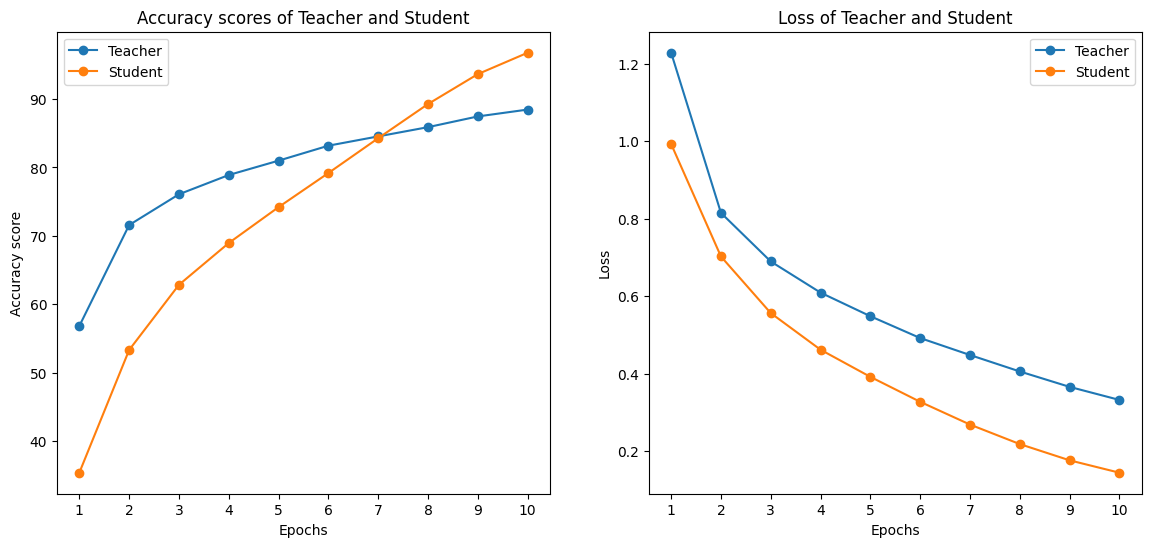

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 10
# Plot 1: Accuracy scores of Teacher and Student
ax1.plot([i+1 for i in range(num_epochs)], vgg16_train_accs, label="Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_accs1, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of Teacher and Student")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Accuracy scores of Teacher and Student
ax2.plot([i+1 for i in range(num_epochs)], vgg16_train_losses, label="Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_losses1, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss of Teacher and Student")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

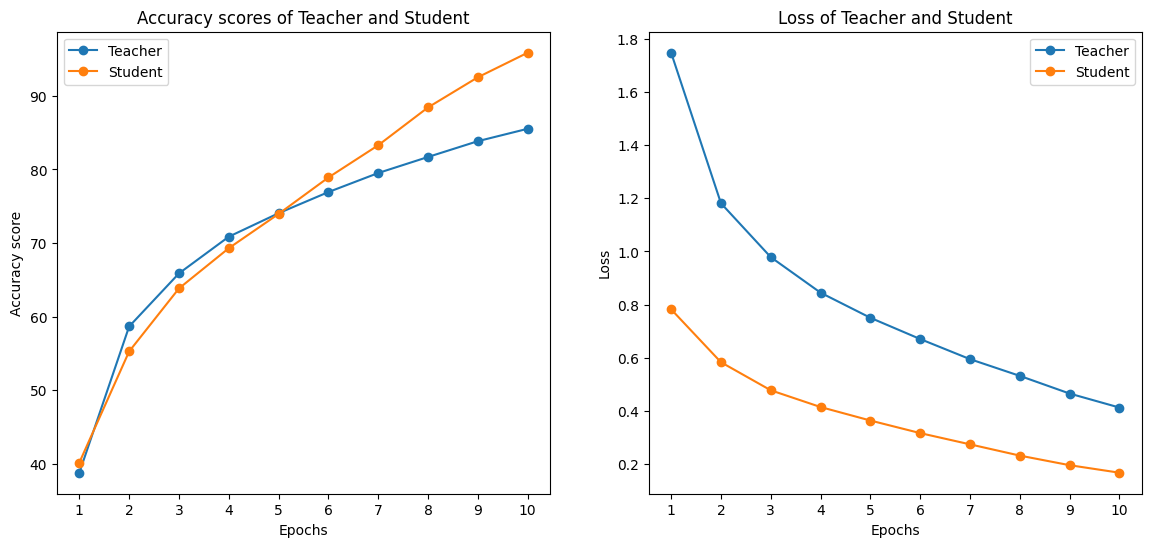

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 10
# Plot 1: Accuracy scores of Teacher and Student
ax1.plot([i+1 for i in range(num_epochs)], resnet50_train_accs, label="Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_accs2, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of Teacher and Student")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Accuracy scores of Teacher and Student
ax2.plot([i+1 for i in range(num_epochs)], resnet50_train_losses, label="Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_losses2, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss of Teacher and Student")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

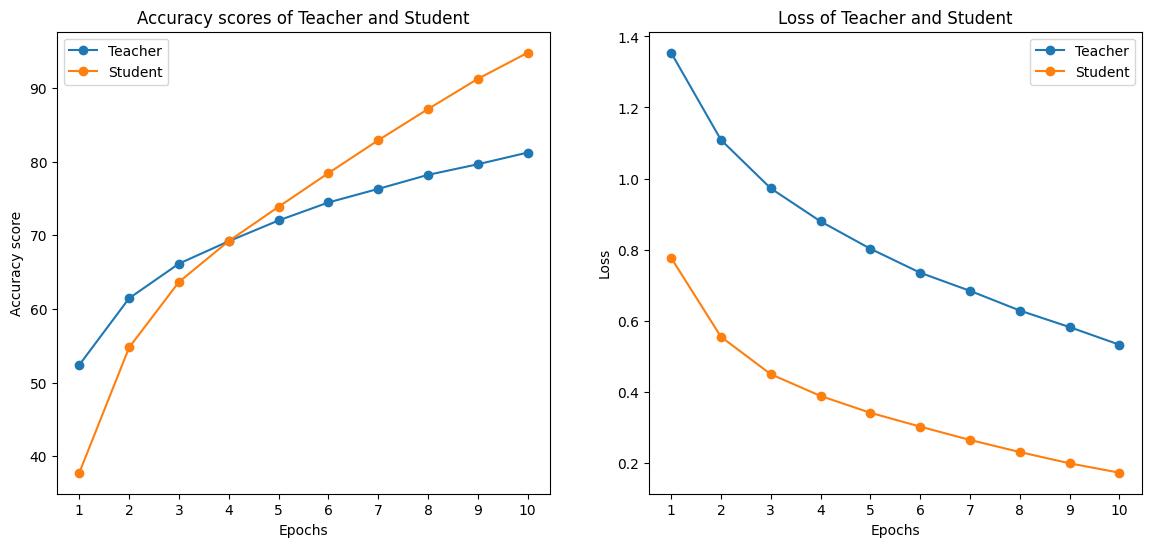

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 10
# Plot 1: Accuracy scores of Teacher and Student
ax1.plot([i+1 for i in range(num_epochs)], resnet34_train_accs, label="Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_accs3, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of Teacher and Student")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Accuracy scores of Teacher and Student
ax2.plot([i+1 for i in range(num_epochs)], resnet34_train_losses, label="Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_losses3, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss of Teacher and Student")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

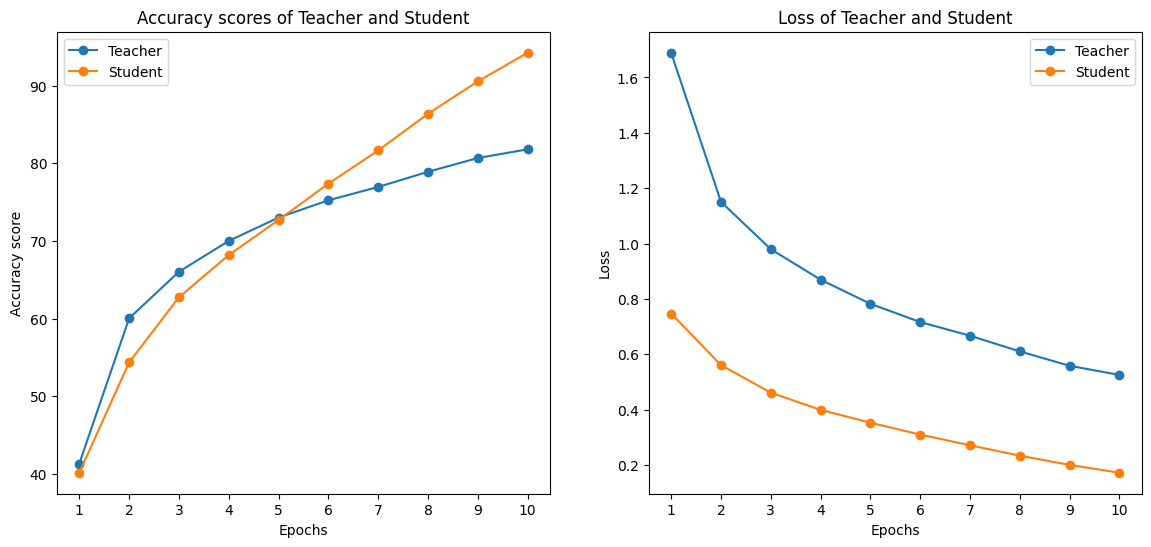

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 10
# Plot 1: Accuracy scores of Teacher and Student
ax1.plot([i+1 for i in range(num_epochs)], densenet121_train_accs, label="Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_accs4, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of Teacher and Student")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Accuracy scores of Teacher and Student
ax2.plot([i+1 for i in range(num_epochs)], densenet121_train_losses, label="Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_losses4, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss of Teacher and Student")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

# **SVHN**

## VGG16

In [ ]:
# Load the models
vgg16 = models.vgg16(pretrained=True)

In [ ]:
# Modify the last fully connected layer
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = torch.nn.Linear(num_features, 10)  # Change the output channels to 10

In [ ]:
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.01, momentum=0.9)

In [ ]:
vgg16.train()
vgg16_svhn_train_accs, vgg16_svhn_train_losses, vgg16_svhn_val_accs, vgg16_svhn_val_losses, time1 = train(vgg16, svhn_trainloader, svhn_valloader, batch_size, num_epochs=10)


Epoch:  1 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]

In [ ]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
student_net = StudentModel().to(device)

In [ ]:
temperature = 3
alpha = 0.7

In [ ]:
optimizer = optim.SGD(student_net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 10
student_losses1 = []
student_accs1 = []

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

    with tqdm(total=len(svhn_trainloader)) as pbar:
        for i, data in enumerate(svhn_trainloader):
        
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            teacher_outputs = vgg16(images)
            student_outputs = student_net(images)
            # Compute loss
            loss = nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),
                                    F.softmax(teacher_outputs / temperature, dim=1)) * (temperature**2) * alpha + \
                      nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
            train_acc += acc
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(float(train_acc.item()/(32.0*(i+1)))))
            pbar.update(1)
    student_losses1.append(train_loss)
    student_accs1.append(train_acc.item()/len(svhn_trainloader.dataset))


Epoch:  1 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]

In [ ]:
student_accs1 = [i*100 for i in student_accs1]

In [ ]:
student_accs1

[69.49628502895922,
 86.57735135240546,
 89.19245695118859,
 90.95926207609352,
 92.40039782367052,
 93.65627254821662,
 94.68203358099807,
 95.70974472981142,
 96.56584566781724,
 97.43559741804637]

In [ ]:
student_losses1 = [i/len(svhn_trainloader) for i in student_losses1]

In [ ]:
student_losses1

[0.5290227437755575,
 0.25170512608509843,
 0.20528309603575537,
 0.17591926742040656,
 0.1555153779425215,
 0.13926460321804396,
 0.1261365607645797,
 0.11451049021684001,
 0.10436265042524596,
 0.09525736353254957]

In [ ]:
evaluate(student_net, svhn_testloader, batch_size)

(90.30232716849792, 0.33077450663534574)

## Resnet50

In [ ]:
# Load the models
resnet50 = models.resnet50(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Modify the last fully connected layer
num_features = resnet50.fc.in_features
resnet50.fc = torch.nn.Linear(num_features, 10)

In [ ]:
resnet50.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet50.parameters(), lr=0.01, momentum=0.9)

In [ ]:
resnet50.train()
resnet50_train_accs, resnet50_train_losses, resnet50_val_accs, resnet50_val_losses, time1 = train(resnet50, svhn_trainloader, svhn_valloader, batch_size, num_epochs=10)


Epoch:  1 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]

In [ ]:
print(resnet50_train_losses)

[1.5480669656546504, 0.7502282014394357, 0.5317718818067984, 0.4222707527266096, 0.3585749683379941, 0.3088736304698404, 0.2700509786145693, 0.23677992806563658, 0.20953777563280043, 0.1856334046684368]


In [ ]:
student_net = StudentModel().to(device)

In [ ]:
temperature = 3
alpha = 0.7

In [ ]:
optimizer = optim.SGD(student_net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 10
student_losses2 = []
student_accs2 = []

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

    with tqdm(total=len(svhn_trainloader)) as pbar:
        for i, data in enumerate(svhn_trainloader):
        
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            teacher_outputs = resnet50(images)
            student_outputs = student_net(images)
            # Compute loss
            loss = nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),
                                    F.softmax(teacher_outputs / temperature, dim=1)) * (temperature**2) * alpha + \
                      nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
            train_acc += acc
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(float(train_acc.item()/(32.0*(i+1)))))
            pbar.update(1)
    student_losses2.append(train_loss)
    student_accs2.append(train_acc.item()/len(svhn_trainloader.dataset))


Epoch:  1 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]

In [ ]:
student_accs2 = [i*100 for i in student_accs2]

In [ ]:
student_accs2

[55.63291015815442,
 85.80510540377152,
 88.84143606544589,
 90.81300337370074,
 92.06302775015114,
 93.12779110357067,
 94.31346165096824,
 95.26316815850542,
 96.07051619571364,
 96.83106144815616]

In [ ]:
student_losses2 = [i/len(svhn_trainloader) for i in student_losses2]

In [ ]:
student_losses2

[0.7174765189885349,
 0.27350058319675724,
 0.225703174509782,
 0.1983725298300655,
 0.17929976148599397,
 0.16364617584853045,
 0.15071342539690616,
 0.13931516723397072,
 0.12939338353523522,
 0.1207961019265674]

In [ ]:
evaluate(student_net, svhn_testloader, batch_size)

(89.98157373916604, 0.34126170794581223)

## Resnet34

In [ ]:
# Load the models
resnet34 = models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Modify the last fully connected layer
num_features = resnet34.fc.in_features
resnet34.fc = torch.nn.Linear(num_features, 10)

In [ ]:
resnet34.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet34.parameters(), lr=0.01, momentum=0.9)

In [ ]:
resnet34.train()
resnet34_train_accs, resnet34_train_losses, resnet34_val_accs, resnet34_val_losses, time1 = train(resnet34, svhn_trainloader, svhn_valloader, batch_size, num_epochs=10)


Epoch:  1 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]

In [ ]:
print(resnet34_train_losses)

[1.412365978833518, 0.7304172212733229, 0.5442113644505618, 0.4496195451010783, 0.38982507206281125, 0.34372630713278624, 0.3116722264357901, 0.2751839680542573, 0.25465116715517666, 0.22881877551892923]


In [ ]:
student_net = StudentModel().to(device)

In [ ]:
temperature = 3
alpha = 0.7

In [ ]:
optimizer = optim.SGD(student_net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 10
student_losses3 = []
student_accs3 = []

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

    with tqdm(total=len(svhn_trainloader)) as pbar:
        for i, data in enumerate(svhn_trainloader):
        
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            teacher_outputs = resnet34(images)
            student_outputs = student_net(images)
            # Compute loss
            loss = nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),
                                    F.softmax(teacher_outputs / temperature, dim=1)) * (temperature**2) * alpha + \
                      nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
            train_acc += acc
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(float(train_acc.item()/(32.0*(i+1)))))
            pbar.update(1)
    student_losses3.append(train_loss)
    student_accs3.append(train_acc.item()/len(svhn_trainloader.dataset))


Epoch:  1 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]

In [ ]:
student_accs3 = [i*100 for i in student_accs3]

In [ ]:
student_accs3

[56.62551921839349,
 85.51843834708166,
 88.65617504241501,
 90.4912342284366,
 92.03572612570447,
 93.22919713722968,
 94.22570642953255,
 95.16371224087833,
 96.0451646872989,
 96.87981434895376]

In [ ]:
student_losses3 = [i/len(svhn_trainloader) for i in student_losses3]

In [ ]:
student_losses3

[0.6901319889875777,
 0.2702851283479614,
 0.22033915150485334,
 0.19253205654867278,
 0.1730645120339102,
 0.15797159880288156,
 0.1461481133328329,
 0.13502637048020114,
 0.1255444308286225,
 0.11709038532587118]

In [ ]:
evaluate(student_net, svhn_testloader, batch_size)

(90.27502900429945, 0.3290238236626163)

## Densenet-121

In [ ]:
# Load the models
densenet121 = models.densenet121(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Modify the last fully connected layer
num_features = densenet121.classifier.in_features
densenet121.classifier = torch.nn.Linear(num_features, 10)

In [ ]:
densenet121.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet121.parameters(), lr=0.01, momentum=0.9)

In [ ]:
densenet121.train()
densenet121_train_accs, densenet121_train_losses, densenet121_val_accs, densenet121_val_losses, time1 = train(densenet121, svhn_trainloader, svhn_valloader, batch_size, num_epochs=10)


Epoch:  1 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]

In [ ]:
print(densenet121_train_losses)

[1.6003288402084404, 0.8274166057501, 0.582349188788489, 0.466360992370307, 0.4027720969437586, 0.3499746973790735, 0.31143269932370443, 0.2783985634451164, 0.25363198490331157, 0.22993935496591064]


In [ ]:
student_net = StudentModel().to(device)

In [ ]:
temperature = 3
alpha = 0.7

In [ ]:
optimizer = optim.SGD(student_net.parameters(), lr=0.01, momentum=0.9)

In [ ]:
num_epochs = 10
student_losses4 = []
student_accs4 = []

for epoch in range(num_epochs):
    train_loss, train_acc = 0, 0
    print("\nEpoch: ", str(epoch+1), "/", str(num_epochs))

    with tqdm(total=len(svhn_trainloader)) as pbar:
        for i, data in enumerate(svhn_trainloader):
        
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            teacher_outputs = densenet121(images)
            student_outputs = student_net(images)
            # Compute loss
            loss = nn.KLDivLoss()(F.log_softmax(student_outputs / temperature, dim=1),
                                    F.softmax(teacher_outputs / temperature, dim=1)) * (temperature**2) * alpha + \
                      nn.CrossEntropyLoss()(student_outputs, labels) * (1. - alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            acc = torch.sum(torch.argmax(student_outputs, dim=1) == labels)
            train_acc += acc
            pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()),
                             Accuracy='{0:.4f}'.format(float(train_acc.item()/(32.0*(i+1)))))
            pbar.update(1)
    student_losses4.append(train_loss)
    student_accs4.append(train_acc.item()/len(svhn_trainloader.dataset))


Epoch:  1 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  2 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  3 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  4 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  5 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  6 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  7 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  8 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  9 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]


Epoch:  10 / 10


  0%|          | 0/1603 [00:00<?, ?it/s]

In [ ]:
student_accs4 = [i*100 for i in student_accs4]

In [ ]:
student_accs4

[58.59903664268023,
 86.3881900973108,
 89.36406716199615,
 91.0431170654654,
 92.57785838257377,
 93.64847208408901,
 94.56112638702002,
 95.55568556329102,
 96.3493827882759,
 97.13527954913317]

In [ ]:
student_losses4 = [i/len(svhn_trainloader) for i in student_losses4]

In [ ]:
student_losses4

[0.651976368833317,
 0.25585240495164024,
 0.21057609383177178,
 0.18573236814046457,
 0.16762792406904645,
 0.15367184815020837,
 0.1420147152744229,
 0.1316527815736686,
 0.12295832479615473,
 0.11403924524691131]

In [ ]:
evaluate(student_net, svhn_testloader, batch_size)

(89.77683750767761, 0.34473682913164644)

## Plots for Accuracies and Losses comparison of 4 Students and their teachers 

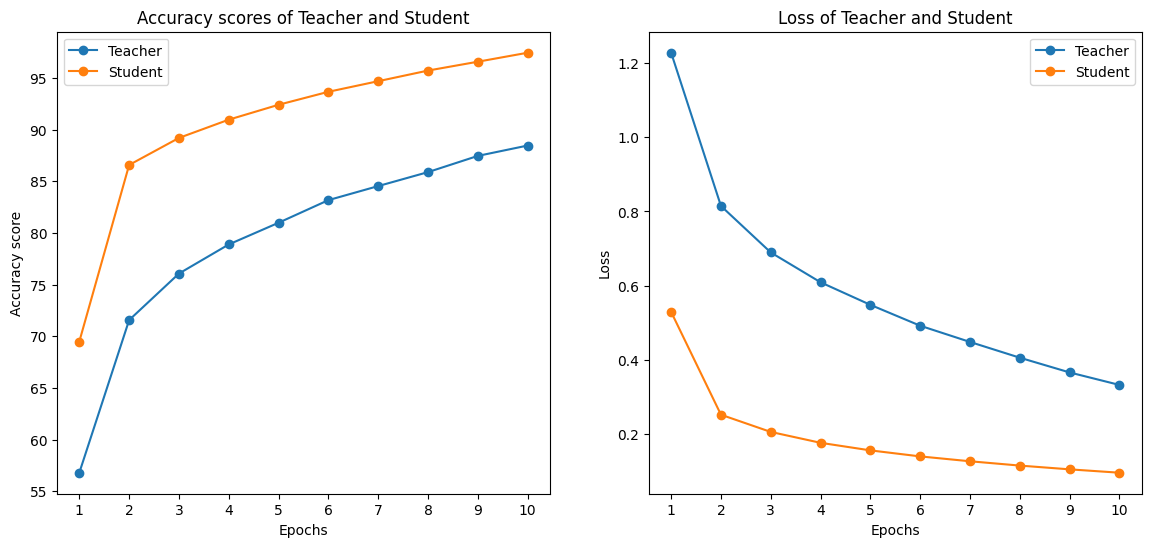

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 10
# Plot 1: Accuracy scores of Teacher and Student
ax1.plot([i+1 for i in range(num_epochs)], vgg16_train_accs, label="Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_accs1, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of Teacher and Student")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Accuracy scores of Teacher and Student
ax2.plot([i+1 for i in range(num_epochs)], vgg16_train_losses, label="Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_losses1, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss of Teacher and Student")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

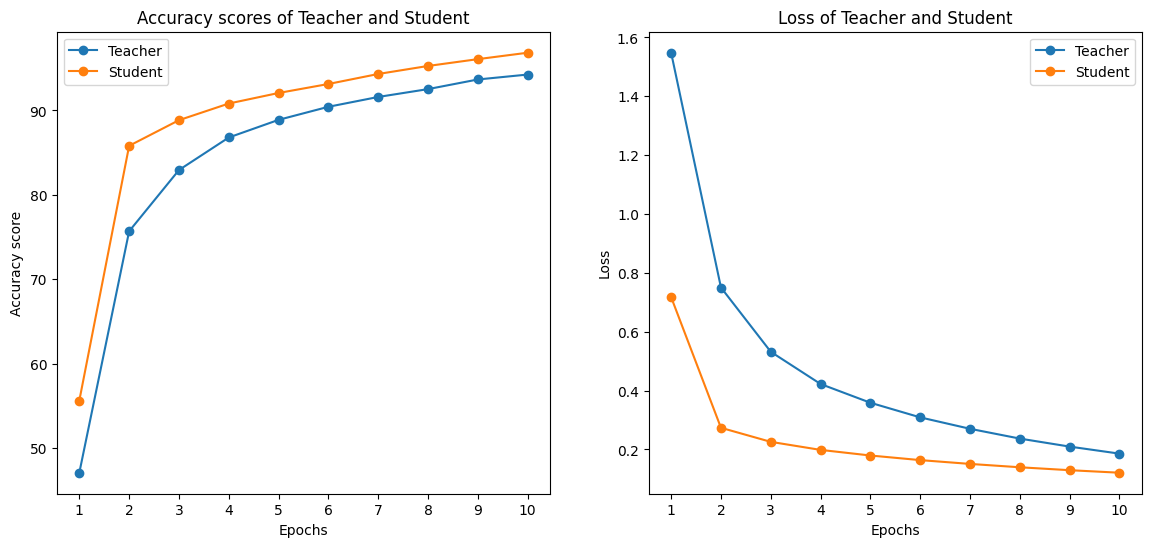

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 10
# Plot 1: Accuracy scores of Teacher and Student
ax1.plot([i+1 for i in range(num_epochs)], resnet50_train_accs, label="Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_accs2, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of Teacher and Student")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Accuracy scores of Teacher and Student
ax2.plot([i+1 for i in range(num_epochs)], resnet50_train_losses, label="Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_losses2, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss of Teacher and Student")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

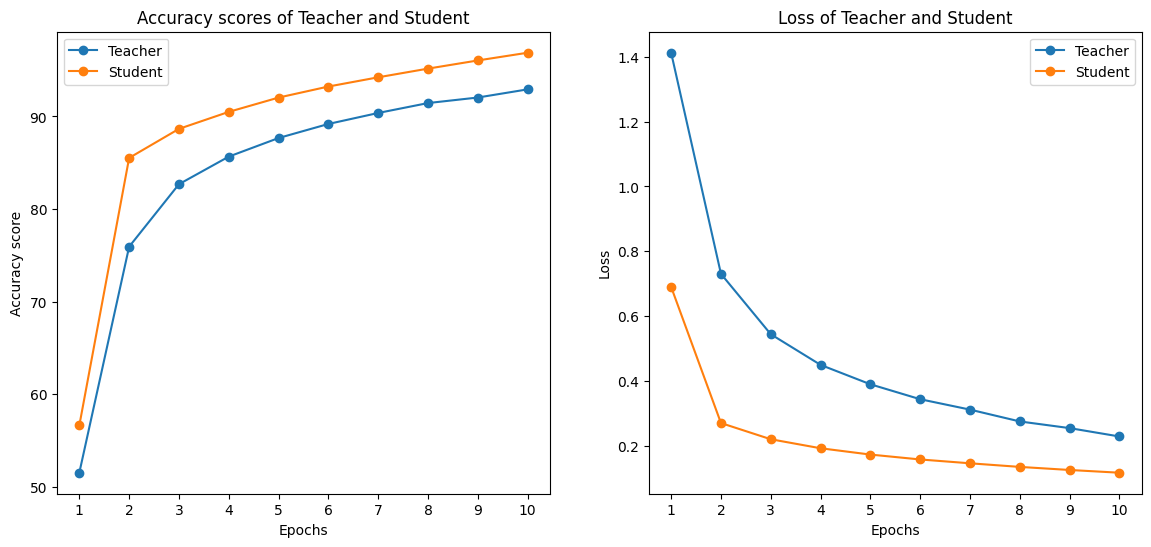

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 10
# Plot 1: Accuracy scores of Teacher and Student
ax1.plot([i+1 for i in range(num_epochs)], resnet34_train_accs, label="Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_accs3, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of Teacher and Student")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Accuracy scores of Teacher and Student
ax2.plot([i+1 for i in range(num_epochs)], resnet34_train_losses, label="Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_losses3, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss of Teacher and Student")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()

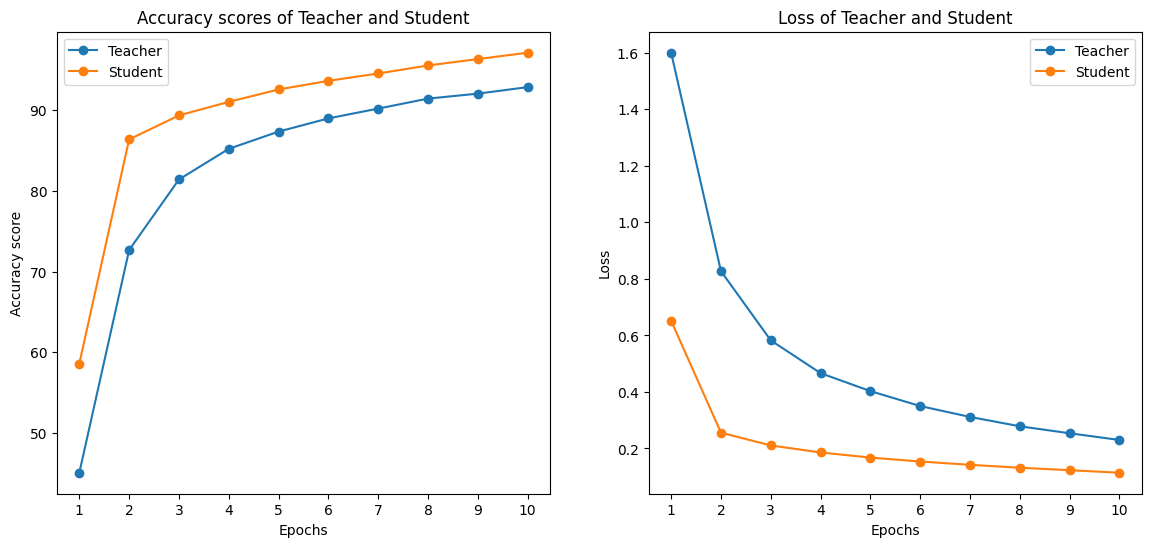

In [ ]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
num_epochs = 10
# Plot 1: Accuracy scores of Teacher and Student
ax1.plot([i+1 for i in range(num_epochs)], densenet121_train_accs, label="Teacher", marker='o')
ax1.plot([i+1 for i in range(num_epochs)], student_accs4, label="Student", marker='o')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy score")
ax1.set_title("Accuracy scores of Teacher and Student")
ax1.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax1.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax1.legend()

# Plot 2: Accuracy scores of Teacher and Student
ax2.plot([i+1 for i in range(num_epochs)], densenet121_train_losses, label="Teacher", marker='o')
ax2.plot([i+1 for i in range(num_epochs)], student_losses4, label="Student", marker='o')
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.set_title("Loss of Teacher and Student")
ax2.set_xticks(ticks=[i+1 for i in range(num_epochs)])
ax2.set_xticklabels(labels=[i+1 for i in range(num_epochs)])
ax2.legend()

plt.show()